### Problem

Recently I had to solve a machine learning problem that involved online learning, i.e. updating the weights of your model only with incoming batches of data. This is opposed to the much more familiar offline training paradigm where you cycle through multiple epochs over a single dataset.

There’s lots of potential use cases for this - think of any situation where you want your model continuously updating as data is simultaneously coming in (e.g. streaming apps, stock market prediction, etc.). The problem arises that the ‘right’ way of updating your model depends heavily on how much you want to balance new vs old data in terms of its influence on the the model. On top of this, even if you want to treat all data points equally, a new learning rate must still be chosen at each update, and this is non-trivial given that you don’t know anything about future samples.

Do a quick search online and you will find lots of lengthy [discussions](https://medium.com/value-stream-design/online-machine-learning-515556ff72c5) of this problem as well as [research papers](https://arxiv.org/abs/1802.02871) that address it. Surprisingly, I found very few examples of simple proof-of-concepts with working code. Here I will aim to create just that.

### Proposed solution

This post will show how to use bayesian inference to iteratively update a model's weights with each new batch of data. The key insight here is that bayesian updates are implemented quite naturally by simply resetting the prior distribution to whatever the posterior was, and then recalculating the new posterior based on the new data. The updated “weights” (the way we think of them in a frequentist sense) correspond to the mode of the most recently updated posterior. Note that this method does treat all data points equally, regardless of time, but that’s a simplifying assumption that’s helpful for now.

Here I’ll give an example using a simple logistic regression.

With a model like this, the updates are easy (and fast!) to calculate via quadratic approximation of the posterior in PyMC. Later I’ll mention some more generalizable frameworks for approximating the posterior with neural networks.

### Import

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pymc as pm
import seaborn as sns
from scipy.stats import norm

### Simulate some data for a logistic regression

(doesn’t matter how, as long as we can visualize a decision boundary)

I’ll use 100 samples for simplicity. The idea is that I'm going to use subsamples of this dataset to fit and update a model, one subsample at a time.

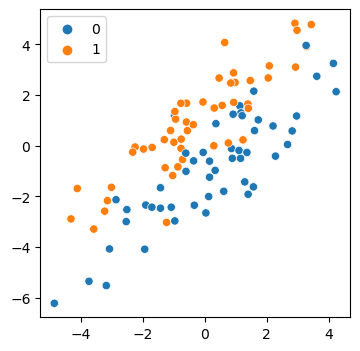

In [ ]:
n_obs = 100

rng = np.random.default_rng()
x0_obs = rng.normal(5, 2, size=n_obs)
y_obs = rng.binomial(1, 0.5, size=n_obs)

y_vec = np.zeros((len(y_obs), 2))
y_vec[np.arange(len(y_obs)), y_obs] = 1
mu_obs = y_vec @ np.array([1, 3]) + (y_vec @ np.array([1, 1])) * x0_obs
x1_obs = rng.normal(mu_obs, 1)

x0_obs = x0_obs - x0_obs.mean()
x1_obs = x1_obs - x1_obs.mean()
x_obs = np.concatenate(([np.ones(x0_obs.shape[0])], [x0_obs], [x1_obs])).T

plt.figure(figsize=(4, 4))
sns.scatterplot(x=x0_obs, y=x1_obs, hue=y_obs)
plt.show()

### Specify the model & obtain the first posterior

Using just the first batch of 10 samples

(and I’ll say to update the model a total of 10 times after that, 10 samples at a time)

In [ ]:
steps = 10

num_features = x_obs.shape[1]
step = n_obs // steps
x_start = x_obs[:step, :]
y_start = y_obs[:step]

with pm.Model() as start_model:
    # use Normal as priors
    # w is our list of model weights
    w = pm.Normal("w", 0, 10, shape=num_features)
    p = pm.math.invlogit(x_start @ w)
    # likelihood function
    y = pm.Binomial("y", 1, p, observed=y_start)

    # estimate the posterior as a gaussian
    mean_w = pm.find_MAP()
    hess = pm.find_hessian(mean_w, vars=[w])
    var_cov = np.linalg.inv(hess)
    std_w = np.sqrt(np.diag(var_cov))

### Code explanation

Let me summarize what’s going on here:

Our model has 3 weights (2 + bias), are denoted by `w`, and each given a prior with a mean of 0 and stdev of 10

The likelihood function is specified here as a bernoulli (or binomial with n=1) with p being a sigmoid function of inputs * weights

PyMC enables bayesian inference either through estimation or sampling of the posterior. In this case, we estimate it directly by finding the maximum of the posterior (analogous to maximum likelihood estimation) and describing its curvature with the hessian (a matrix of second-order partial derivatives). If we assume the shape of the posterior is gaussian, the hessian is sufficient to derive its standard deviation. Note that we could also sample the posterior instead, but that would be more expensive and won’t scale to n-dimensional problems.

Notice then that the whole posterior for `w` is described by only two terms: mean_w and std_w (the mean/mode of a gaussian and its standard deviation). We can view their current values:

In [ ]:
print("means:", mean_w["w"])
print("standard devs:", std_w)

means: [ 1.31026875 -5.99367736  6.3300888 ]
standard devs: [2.07364747 3.53659583 3.7744848 ]


### Subsequent updates

For subsequent updates, all we need is to reset our prior on `w` to the posterior we just found. The next posterior is discovered by simply repeating the same inference process on a new batch of data.

In [ ]:
mus, sigmas = [], []

for t in range(step, n_obs, step):
    x_new = x_obs[t:t+step]
    y_new = y_obs[t:t+step]
    
    with pm.Model() as updated_model:
        # Reset priors to posteriors from previous iteration, unless weights are fixed
        updated_mus = mean_w["w"]
        updated_sigmas = std_w
        mus.append(updated_mus)
        sigmas.append(updated_sigmas)
        
        w = pm.Normal("w", updated_mus, updated_sigmas, shape=num_features)
        p = pm.math.invlogit(x_new @ w)
        y = pm.Binomial("y", 1, p, observed=y_new)

        mean_w = pm.find_MAP()
        hess = pm.find_hessian(mean_w, vars=[w])
        var_cov = np.linalg.inv(hess)
        std_w = np.sqrt(np.diag(var_cov))

Plot changes to the posterior with each update

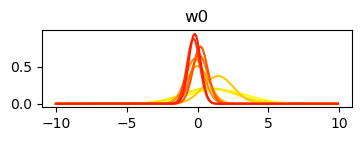

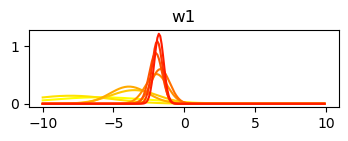

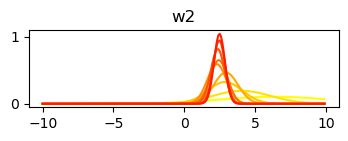

In [ ]:
mus = np.array(mus)
sigmas = np.array(sigmas)
cmap = matplotlib.cm.autumn
x_axis = np.arange(-10, 10, 0.1)

for j in range(mus.shape[1]):
    plt.figure(figsize=(4, 1))
    plt.title(f"w{j}")
    for c, (mu, sigma) in enumerate(zip(mus[:, j], sigmas[:, j])):
        plt.plot(x_axis, norm.pdf(x_axis, mu, sigma), color=cmap(1 - c / mus.shape[0]))

In order to see the decision boundary, I need the weights as point estimates, so I just take the mean of the posterior.

Below shows how the decision boundary changed with each update.

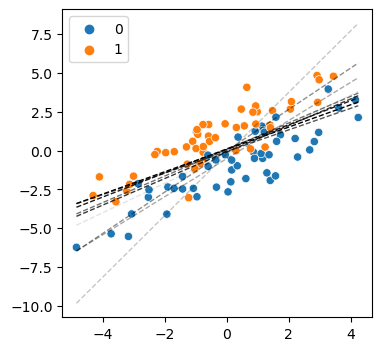

In [ ]:
plt.figure(figsize=(4, 4))
sns.scatterplot(x=x0_obs, y=x1_obs, hue=y_obs.flatten())

alpha0 = alpha = 1 / mus.shape[0]
for mu in mus:
    w0, w1, w2 = mu
    b = -w0/w2
    m = -w1/w2
    xd = np.array([x0_obs.min(), x0_obs.max()])
    yd = m*xd + b
    plt.plot(xd, yd, 'k', lw=1, ls='--', alpha=min(alpha, 1))
    alpha += alpha0

plt.show()

The figure shows the decision boundary at each update, where the darker lines show the later updates. You can see the initial lines are a bit wonky, but as new data is added the updates converge on a good estimate of the boundary.

And that’s it! Note that because it is actually the full posterior that is estimated, and not just the point estimate of its maximum, I can continue updating the model in perpetuity as new data arrives and still be able to recover point estimates of the weights at any time.

### Further reading

Just as I’ve implemented this solution as a bayesian regression, the same basic approach could be taken using more complex (e.g. deep) models by implementing them as bayesian neural networks (e.g. check out [pyro](http://pyro.ai/examples/intro_long.html) or this more lightweight and very impressive [package](https://github.com/Harry24k/bayesian-neural-network-pytorch)). Updating bayesian NNs will rely on more advanced methods than the quadratic approximations done here (e.g. variational inference), but these can also be implemented an online fashion by continually resetting posteriors <-> priors.